# Role of similarity-aware split

This notebook analyzes the differences between the similarity-aware and the random split. The results are shown and described in the accompanying paper.

In [1]:
import sys
sys.path.insert(0, '..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import pickle
from sklearn.metrics import auc
from wildlife_datasets import datasets
from utils import predict, compute_baks_baus, make_radar_plot

In [2]:
root = '/data/wildlife_datasets/data/WildlifeReID10k'
root_images = os.path.join(root, 'images')
save_clusters_prefix = 'clusters/cluster'
d = datasets.WildlifeReID10k(root)
d.df['date'] = pd.to_datetime(d.df['date'])
df = d.df
labels = d.df['identity'].to_numpy()

features_dino = np.load('features/features_dino.npy')
features_md_similarity = torch.load('features/MD-L-384_similarity.pth')
features_md_random = torch.load('features/MD-L-384_random.pth')

In [3]:
new_individual = 'new_individual'
data = [
    ('md_similarity', features_md_similarity, 'split'),
    ('md_random', features_md_random, 'split_random'),
    ('dino_similarity', features_dino, 'split'),
    ('dino_random', features_dino, 'split_random'),
]
step = 0.01
ts = [-np.inf] + list(np.arange(0, 1+step/10, step)) + [np.inf]
file_name = 'features/results.pickle'

if not os.path.exists(file_name):
    results = {t: {} for t in ts}
    for features_name, features, split_col in data:
        print(features_name)
        y_pred_closed, similarity_pred = predict(df, features, split_col=split_col)
        for t in ts:
            print(t)
            y_pred = copy.copy(y_pred_closed)
            with np.errstate(invalid='ignore'):
                y_pred[similarity_pred < t] = new_individual
            baks, baus = compute_baks_baus(df, y_pred, new_individual=new_individual, split_col=split_col)
            results[t][f'{features_name}_BAKS'] = baks
            results[t][f'{features_name}_BAUS'] = baus
    results = {t: pd.DataFrame(results[t]) for t in ts}
    with open(file_name, 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(file_name, 'rb') as handle:
        results = pickle.load(handle)     

In [4]:
for t in ts:
    metric = 'BAKS'
    results[t][f'diff_md_{metric}'] = results[t][f'md_random_{metric}'] - results[t][f'md_similarity_{metric}']
    results[t][f'diff_dino_{metric}'] = results[t][f'dino_random_{metric}'] - results[t][f'dino_similarity_{metric}']

In [5]:
print(results[np.min(ts)]['diff_md_BAKS'].mean())
print(results[np.min(ts)]['diff_dino_BAKS'].mean())

idx = (results[np.min(ts)]['md_similarity_BAKS'] >= 0.99) * (results[np.min(ts)]['md_random_BAKS'] >= 0.99)
print(results[np.min(ts)]['diff_md_BAKS'][~idx].mean())
print(results[np.min(ts)]['diff_dino_BAKS'][~idx].mean())

0.0038466041793673873
0.03107369345083209
0.005574912079416387
0.03716089679978529


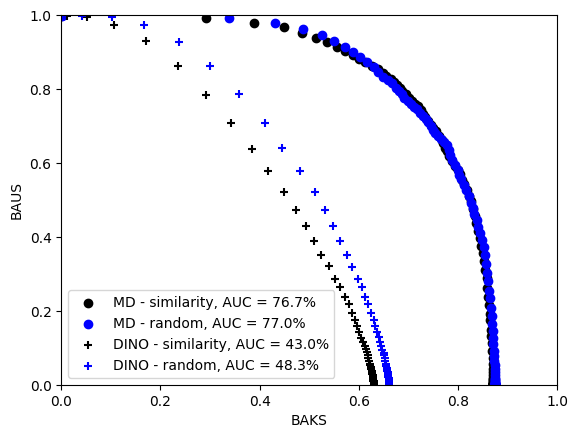

In [6]:
md_similarity_baks = [results[t]['md_similarity_BAKS'].mean() for t in ts]
md_similarity_baus = [results[t]['md_similarity_BAUS'].mean() for t in ts]
md_random_baks = [results[t]['md_random_BAKS'].mean() for t in ts]
md_random_baus = [results[t]['md_random_BAUS'].mean() for t in ts]
dino_similarity_baks = [results[t]['dino_similarity_BAKS'].mean() for t in ts]
dino_similarity_baus = [results[t]['dino_similarity_BAUS'].mean() for t in ts]
dino_random_baks = [results[t]['dino_random_BAKS'].mean() for t in ts]
dino_random_baus = [results[t]['dino_random_BAUS'].mean() for t in ts]
aucs = [auc(md_similarity_baks, md_similarity_baus), auc(md_random_baks, md_random_baus), auc(dino_similarity_baks, dino_similarity_baus), auc(dino_random_baks, dino_random_baus)]
legend = ['MD - similarity' , 'MD - random', 'DINO - similarity', 'DINO - random']
legend = [f'{l}, AUC = {str(np.round(100*a,1)) + "%"}' for (l, a) in zip(legend, aucs)]

plt.figure()
plt.scatter(md_similarity_baks, md_similarity_baus, color='black')
plt.scatter(md_random_baks, md_random_baus, color='blue')
plt.scatter(dino_similarity_baks, dino_similarity_baus, color='black', marker='+')
plt.scatter(dino_random_baks, dino_random_baus, color='blue', marker='+')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('BAKS')
plt.ylabel('BAUS')
plt.legend(legend)

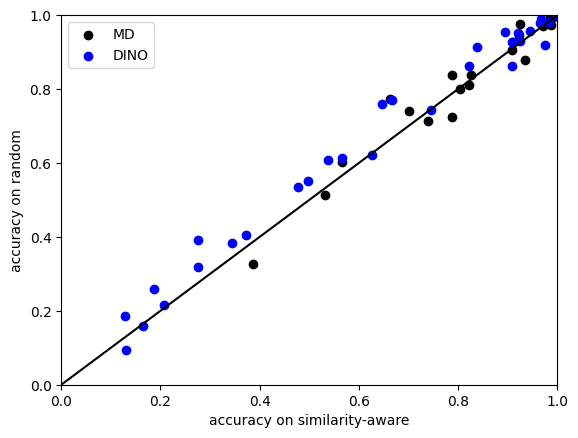

In [7]:
plt.scatter(results[np.min(ts)]['md_similarity_BAKS'].values, results[np.min(ts)]['md_random_BAKS'].values, color='black')
plt.scatter(results[np.min(ts)]['dino_similarity_BAKS'].values, results[np.min(ts)]['dino_random_BAKS'].values, color='blue')
plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('accuracy on similarity-aware')
plt.ylabel('accuracy on random')
plt.legend(['MD', 'DINO'])

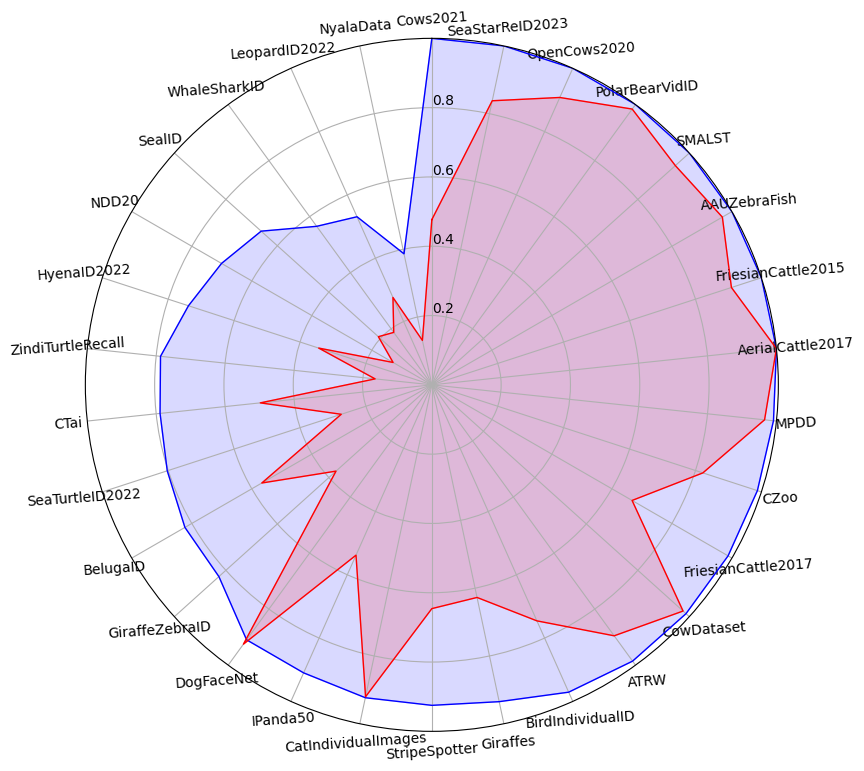

In [8]:
results_closed = results[np.min(ts)].copy()
results_closed = results_closed.sort_values('md_similarity_BAKS', ascending=False)

make_radar_plot(results_closed, 'blue', use_col='md_similarity_BAKS')
make_radar_plot(results_closed, 'red', use_col='dino_similarity_BAKS', fontsize=10, rotation=4)

In [9]:
results_clusters = {dataset: {'all': 0, 'unique day': 0} for dataset in d.df['dataset'].unique()}
for file_name in os.listdir('clusters'):
    clusters = pd.read_csv(f'clusters/{file_name}', index_col=0)
    for cluster, df_cluster in clusters.groupby('cluster'):
        if cluster != -1:
            df_red = d.df.loc[df_cluster.index]
            if not any(df_red['date'].isnull()):
                if df_red['dataset'].nunique() != 1:
                    raise Exception('Something wrong')
                dataset = df_red['dataset'].iloc[0]
                results_clusters[dataset]['all'] += len(df_cluster)
                if df_red['date'].nunique() == 1:
                    results_clusters[dataset]['unique day'] += len(df_cluster)
results_clusters = pd.DataFrame(results_clusters).T
results_clusters = results_clusters[results_clusters['all'] + results_clusters['unique day'] > 0]
results_clusters.loc['TOTAL'] = results_clusters.sum()
results_clusters

,all,unique day
BelugaID,2125,2036
Cows2021,1458,942
GiraffeZebraID,841,724
SeaTurtleID2022,2384,1509
StripeSpotter,200,200
WhaleSharkID,164,47
TOTAL,7172,5458
